## SHAP LGBM


In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap
import lightgbm as lgb
#%matplotlib inline

In [2]:
data = pd.read_csv('regression/final_elem_SP.csv')
data = data.drop(['Bandgap','TC_a','D_a','MEN_V_a','Mean_NfValence','EA_b','r_a',
'Mean_NdValence','r_b','Mean_GSbandgap','Number','Mean_GSmagmom','Mean_NfUnfilled',
'AM_b','MP_b','Mean_NsUnfilled','Mean_NsValence','MeanColumn','MEN_V_b',
'Mean_NdUnfilled','TC_b','D_b'], axis=1)
X = data.iloc[:,2:-1]
Y = data.iloc[:,1]

In [3]:
def read_param():  ## function for reading saved hyperparameters
    f0 = open('regression/best-paramters_lgb_optuna_TPE_plot_SP_NOBANDGAP.txt','r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = float(b[1][1]); p2 = float(b[2][1]); p3 = int(b[3][1]); p4 = float(b[4][1])
    p5 = float(b[5][1]); p6 = int(b[6][1]); p7 = int(b[7][1]); p8 = float(b[8][1])
#     p9 = int(b[9][1])
    return p1, p2, p3, p4, p5, p6, p7, p8

p1, p2, p3, p4, p5, p6, p7, p8 = read_param()
params = {'objective': 'regression', 'boosting_type': 'gbdt', 'lambda_l1': p1,
          'lambda_l2': p2, 'num_leaves': p3, 'feature_fraction': p4, 
          'bagging_fraction': p5, 'bagging_freq': p6, 'min_child_samples': p7,
          'learning_rate': p8} 

In [4]:
## retrieving the best model
random = 595 ## change accordingly
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = random)
reg = lgb.Booster(model_file='regression/best_model_lgbm_SP_NOBANDGAP.txt')
d_train = lgb.Dataset(X_train, label = Y_train)
reg = lgb.train(params, d_train)
Y_pred_test = reg.predict(X_test) 
Y_pred_train = reg.predict(X_train) 
rmse_test=np.sqrt(mean_squared_error(Y_test, Y_pred_test))
rmse_train=np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print(rmse_train, rmse_test) ## compare with the one obtained from finding the best ML model step

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4395
[LightGBM] [Info] Number of data points in the train set: 4749, number of used features: 25
[LightGBM] [Info] Start training from score 209.187568
62.7379801175501 147.86423624441593


## SHAP feature importance plot

## Global Interpretability

In [5]:
explainerModel = shap.TreeExplainer(model = reg)
shap_values = explainerModel.shap_values(X)

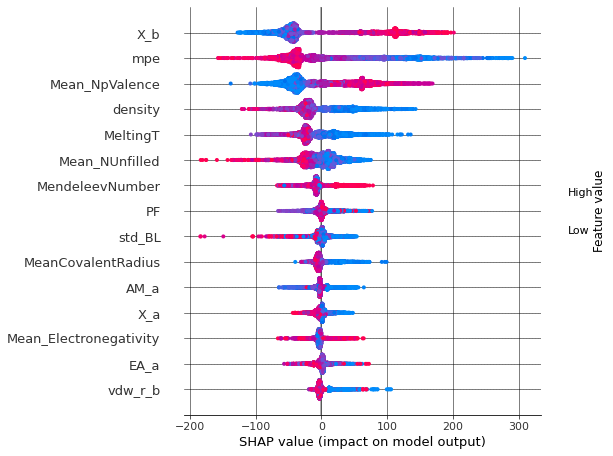

<Figure size 432x288 with 0 Axes>

In [7]:
## Summary plot (Global interpretability)
plt.figure(figsize=(20,20))
plt.grid(color='black', linestyle='-', linewidth=0.5)
shap.summary_plot(shap_values, features = X, feature_names=X.columns, color=plt.get_cmap("coolwarm"), max_display=15)
plt.show()
plt.savefig('images/shap_feature-importancenobandgap.tif',bbox_inches='tight',  dpi=1000)

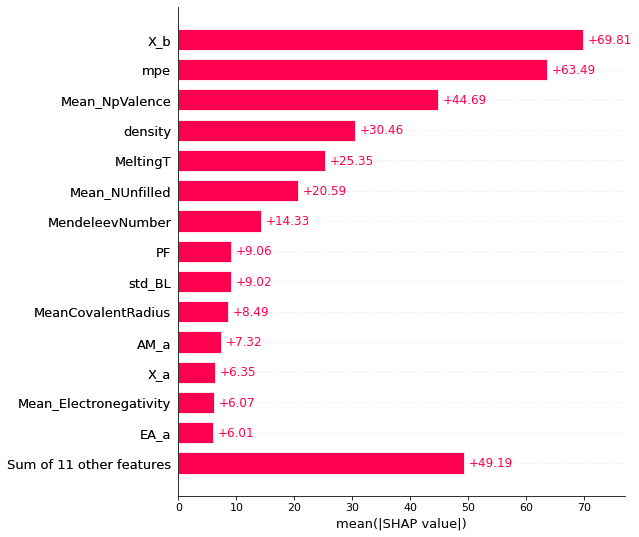

<Figure size 432x288 with 0 Axes>

In [9]:
import shap
plt.figure(figsize=(20,20))
explainer = shap.Explainer(reg)
shap_values = explainer(X)
shap.plots.bar(shap_values, max_display=15) # default is max_display=12
plt.savefig('images/shap_feature-importancenobandgap.tif',bbox_inches='tight',  dpi=1000)

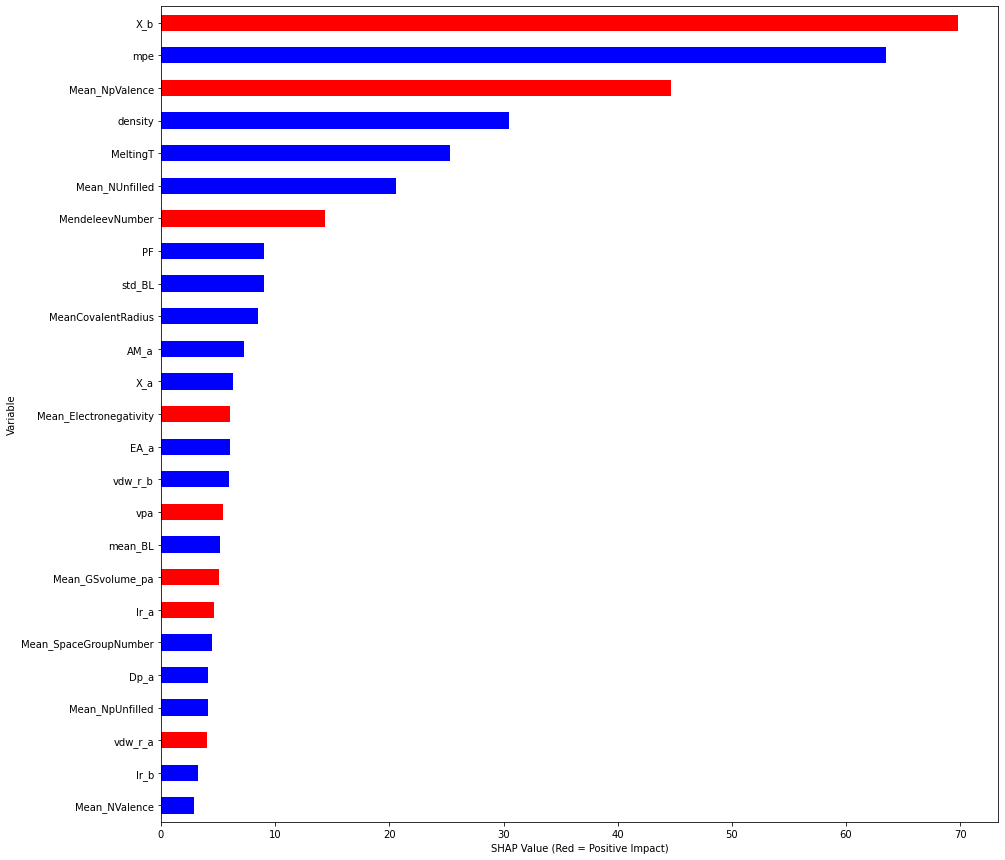

In [11]:
## 2nd type of bar plot of feature importance 
def abs_shap(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(15,15),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    plt.savefig('images/shap_feature-import_bar_convexnobandgap.tif', bbox_inches='tight', dpi=1000)

shap_values = explainerModel.shap_values(X)   
abs_shap(shap_values, X)

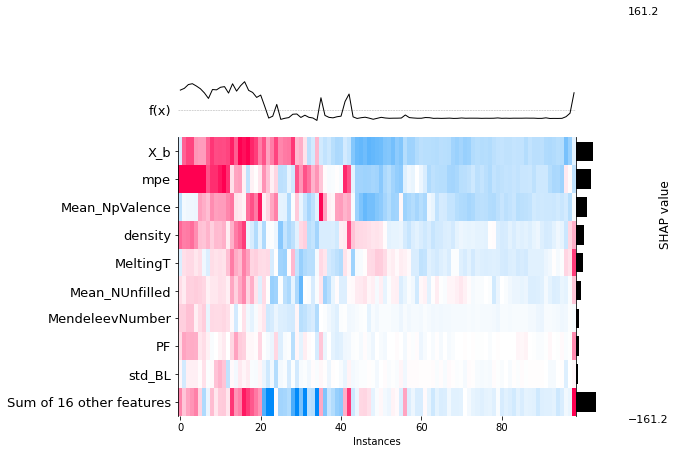

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [12]:
import shap
explainer = shap.Explainer(reg)
shap_values = explainer(X)
shap.plots.heatmap(shap_values[1:100])
plt.figure(figsize=(20,20))
#plt.savefig('final_images/shap_feature-heatmap.png',bbox_inches='tight',  dpi=1000)

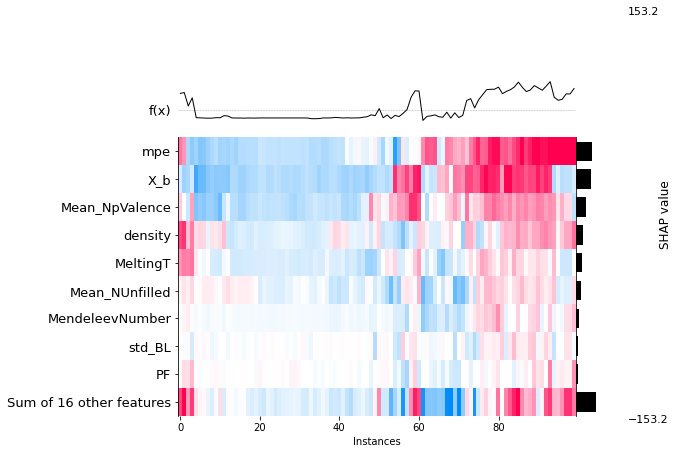

<Figure size 432x288 with 0 Axes>

In [13]:
import shap
explainer = shap.Explainer(reg)
shap_values = explainer(X)
shap.plots.heatmap(shap_values[100:200])
plt.savefig('images/shap_feature-heatmap2.png',bbox_inches='tight',  dpi=1000)

## Shap Interaction values

In [14]:
#Get SHAP interaction values
explainer = shap.TreeExplainer(reg)
shap_interaction = explainer.shap_interaction_values(X)

In [15]:
#Get shape of interaction values
print(np.shape(shap_interaction))

# SHAP interaction values for first compounds
pd.DataFrame(shap_interaction[0],index=X.columns,columns=X.columns)

(6785, 25, 25)


,mpe,PF,X_b,std_BL,mean_BL,vdw_r_b,Mean_NpValence,Mean_Electronegativity,density,vdw_r_a,...,Mean_NUnfilled,MeltingT,Mean_NValence,X_a,Mean_GSvolume_pa,Mean_SpaceGroupNumber,MeanCovalentRadius,Dp_a,Mean_NpUnfilled,AM_a
mpe,200.215753,-2.843581,-62.676685,0.490349,-2.991531,-13.400294,-16.409405,-0.546297,-10.334223,-0.686049,...,-5.375236,-5.124857,0.896310,-2.685813,-5.581032,-3.107285,-3.601157,-5.272718,2.290395,-0.958365
PF,-2.843581,11.947164,4.041201,1.687639,0.250442,0.375217,-3.643634,-0.429820,-5.105316,-2.664568,...,0.313585,5.332797,-0.939518,-0.653351,-1.330776,-0.020390,-1.551248,-0.956666,1.818244,0.543047
X_b,-62.676685,4.041201,196.132668,-5.137003,-0.921727,-0.745113,-0.560932,-3.241757,-20.207984,1.715203,...,-3.586048,-21.173428,-2.517267,-3.827986,-0.912899,3.384439,-2.976913,-5.324807,0.564030,1.627118
std_BL,0.490349,1.687639,-5.137003,16.573142,0.149527,-0.757892,-0.373147,-5.400003,-5.197271,-0.668994,...,-0.552341,-3.563811,1.401663,-0.502914,-4.438673,-0.024019,-1.790625,-1.729681,-0.023989,-1.295457
mean_BL,-2.991531,0.250442,-0.921727,0.149527,14.397521,0.233578,-1.690496,-5.007573,-2.690181,-0.655905,...,-1.216955,-2.435875,-3.234261,-2.187117,-0.920367,4.160358,-1.765546,-1.008509,-0.333916,0.163550
vdw_r_b,-13.400294,0.375217,-0.745113,-0.757892,0.233578,30.932263,-2.578725,0.711479,-2.560371,0.015554,...,0.454223,0.071973,0.075093,-0.482104,-0.056756,0.024611,1.841178,-0.087908,-0.728696,-0.083147
Mean_NpValence,-16.409405,-3.643634,-0.560932,-0.373147,-1.690496,-2.578725,101.870899,4.409732,0.110150,0.604280,...,-3.450405,-2.416104,-6.718232,-3.881003,-11.415588,0.989393,-6.711296,1.089885,2.588001,4.091333
Mean_Electronegativity,-0.546297,-0.429820,-3.241757,-5.400003,-5.007573,0.711479,4.409732,10.869634,-4.970968,-0.665284,...,-4.064727,-1.785545,-1.330231,-1.287916,0.298170,-3.142331,-2.487824,-1.044516,-0.599417,-0.282225
density,-10.334223,-5.105316,-20.207984,-5.197271,-2.690181,-2.560371,0.110150,-4.970968,-10.038477,-0.362687,...,-4.193629,0.256606,-5.086216,-4.733094,-6.446938,0.346763,-3.855057,-0.665684,0.296718,-3.495968
vdw_r_a,-0.686049,-2.664568,1.715203,-0.668994,-0.655905,0.015554,0.604280,-0.665284,-0.362687,-0.849209,...,0.130125,-0.650411,-0.065620,-0.521952,-1.187769,0.188695,-1.043666,0.186701,-0.002017,-0.407178


In [16]:
#Get model predictions
y_pred = reg.predict(X)

#Calculate mean prediction 
mean_pred = np.mean(y_pred)

#Sum of interaction values for the formation energy
sum_shap = np.sum(shap_interaction[0])

print("Model prediction: {}".format(y_pred[0]))
print("Mean prediction + interaction values: {}".format(mean_pred+sum_shap))

print(mean_pred, sum_shap)

Model prediction: -34.27234497412137
Mean prediction + interaction values: -34.38384722099647
210.572287197212 -244.95613441820848


# Interaction


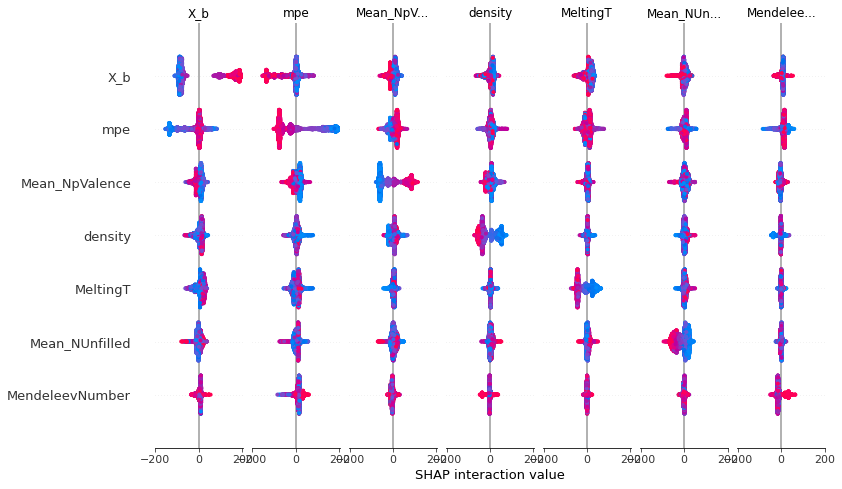

In [17]:
#Display summary plot
shap.summary_plot(shap_interaction, features = X, feature_names=X.columns, color=plt.get_cmap("cool"), max_display=7)
#plt.savefig('final_images3/shap_feature-interaction.png',bbox_inches='tight',  dpi=1000)

## Absolute Mean

In [15]:
# Get absolute mean of matrices
#mean_shap = np.abs(shap_interaction).mean(0)
#df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
#df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
#plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
#sns.set(font_scale=1.5)
#sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False)
#plt.yticks(rotation=0) 
#
#plt.savefig('images/shap_dp_min_Mendeleev_number.png', bbox_inches='tight', dpi=1000)

## SHAP dependence plots

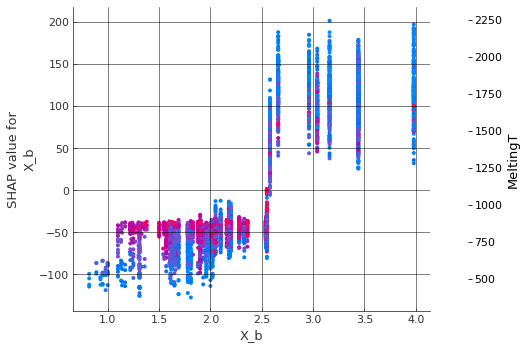

In [18]:
explainerModel = shap.TreeExplainer(model = reg)
shap_values = explainerModel.shap_values(X)
shap.dependence_plot('X_b', shap_values, X, show=False)
#plt.title("Ave. Atomic Radius Dependence Plot")
#plt.ylabel("SHAP value for Ave. Atomic Radius")
#plt.xlabel("Ave. Atomic Radius")
#plt.axis([0.5, 2.0, -1.0, 1.0])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
#plt.savefig('final_images3/shap_dp_avg_Atomic_Radius.png', bbox_inches='tight', dpi=1000)

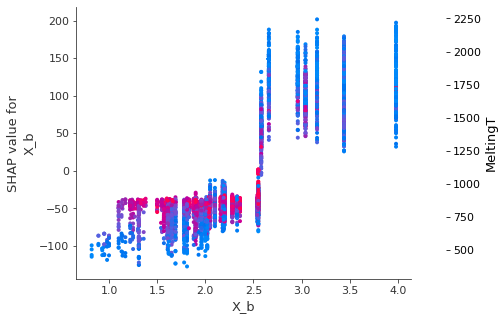

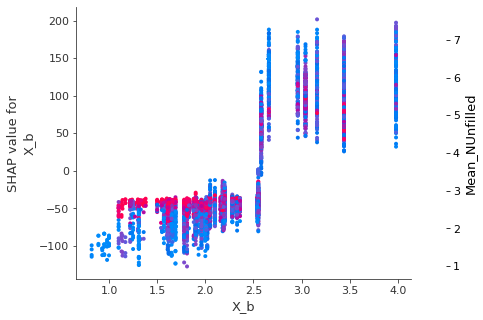

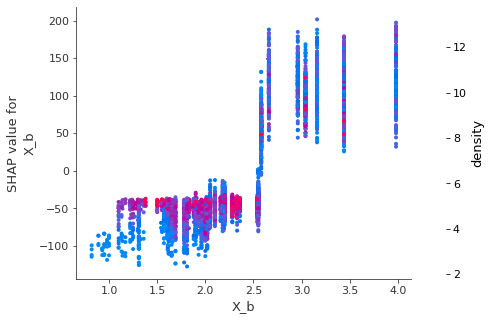

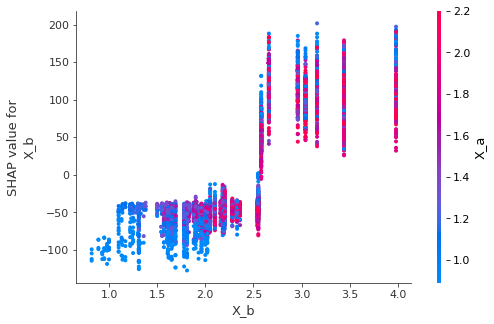

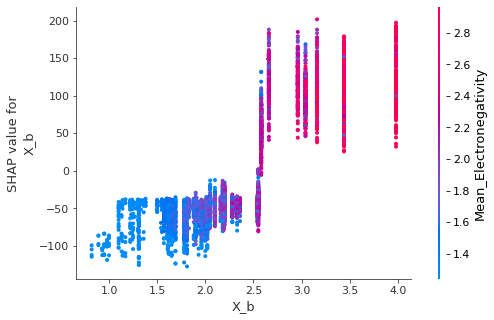

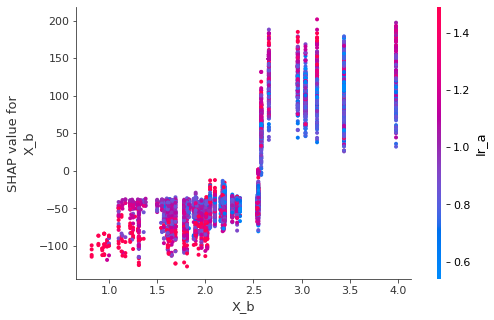

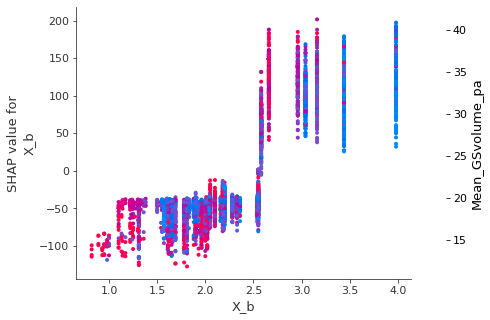

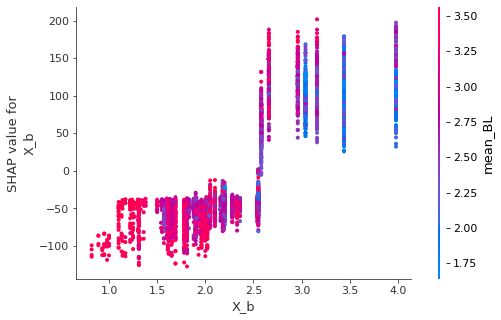

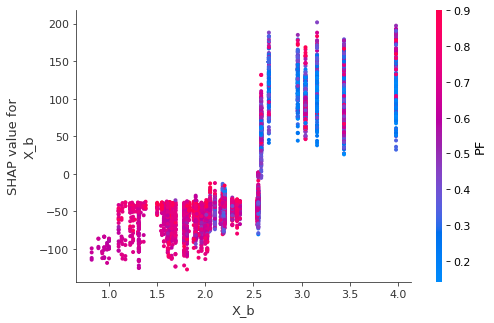

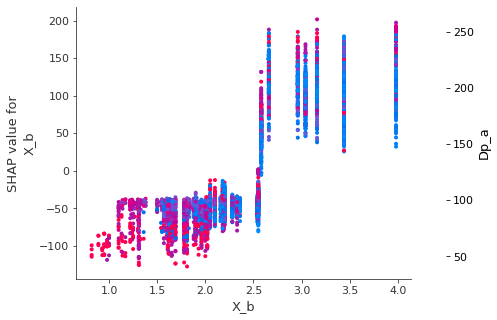

In [19]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
inds = shap.approximate_interactions('X_b', shap_values, X)

# make plots colored by each of the top three possible interacting features
for i in range(10):
    shap.dependence_plot('X_b', shap_values, X, interaction_index=inds[i])



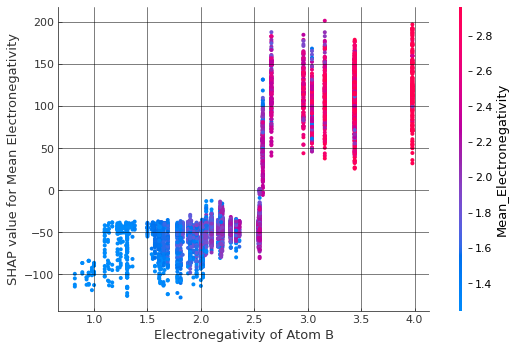

In [21]:
shap.dependence_plot("X_b", shap_values, X, show = False, interaction_index='Mean_Electronegativity')
#plt.title("Range Polarizability Dependence Plot")
plt.ylabel("SHAP value for Mean Electronegativity")
plt.xlabel("Electronegativity of Atom B")
#plt.axis([0.5, 2.1, -1.5, 1.5])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
#plt.savefig('final_images3/shap_dp_range_polarizability.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('range_polarizability', shap_values, X, show = False, interaction_index="avg_Atomic_Radius")
plt.title("Range Polarizability Dependence Plot")
plt.ylabel("SHAP I. for R. Polar. & Ave. Atomic Radius")
plt.xlabel("Range Polarizability")
plt.axis([0.0, 60.0, -0.75, 0.75])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
#plt.savefig('final_images3/shap_dp_range_polarizability.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('range_polarizability', shap_values, X, show = False, interaction_index="avg_Atomic_Radius")
plt.title("Range Polarizability Dependence Plot")
plt.ylabel("SHAP value for Range Polarizability")
plt.xlabel("Range Polarizability")
#plt.axis([0.0, 60.0, -1.25, 0.75])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_range_polarizability.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('range_polarizability', shap_values, X, show = False)
plt.title("Range Polarizability Dependence Plot")
plt.ylabel("SHAP value for Range Polarizability")
plt.xlabel("Range Polarizability")
plt.axis([0.0, 60.0, -1.25, 0.75])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_range_polarizability.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('avg_Density', shap_values, X, show =False)
plt.title("Ave. Density Dependence Plot")
plt.ylabel("SHAP Value for Ave. Density")
plt.xlabel("Ave. Density")
plt.axis([0, 8.5, -0.4,0.3])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_avg_Density.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('avg_l_quantum_number', shap_values, X, show=False)
plt.title("Ave. L. Quantum Number Dependence Plot")
plt.ylabel("SHAP Value for Ave. L. Quantum Number")
plt.xlabel("Ave. L. Quantum Number")
plt.axis([0.0, 2.00, -0.8, 0.4])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_avg_l_quantum_number.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('dev_Atomic_Number', shap_values, X, show=False)
plt.title("Dev. Atomic Number Dependence Plot")
plt.ylabel("SHAP Value for Dev. Atomic Number")
plt.xlabel("Dev. Atomic Number")
plt.axis([0.0, 35.00, -0.8, 0.6])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_dev_Atomic_Number.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('avg_crystal_radius', shap_values, X, show=False)
plt.title("Ave. Crystal Radius Dependence Plot")
plt.ylabel("SHAP Value for Ave. Crystal Radius")
plt.xlabel("Ave. Crystal Radius")
plt.axis([0.4, 1.80, -0.5, 0.4])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_avg_crystal_radius.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('avg_Pauling_Electronegativity', shap_values, X, show=False)
plt.title("Ave. Pauling Electronegativity Dependence Plot")
plt.ylabel("SHAP Value for Ave. Pauling Electronegativity")
plt.xlabel("Ave. Pauling Electronegativity")
#plt.axis([0.4, 1.80, -0.5, 0.4])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_avg_Pauling_Electronegativity.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('min relative bond length', shap_values, X, show=False)
plt.title("Min. Relative Bond Length Dependence Plot")
plt.ylabel("SHAP Value for Min. Relative Bond Length")
plt.xlabel("Min. Relative Bond Length")
plt.axis([0.6, 1.0, -0.3, 0.3])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_min_relative_bond_length.png', bbox_inches='tight', dpi=1000)

## SHAP force plots

In [10]:
## Local interpretability
shap.initjs()
def plot_indiv_shap(i):
    shap.force_plot(explainerModel.expected_value, shap_values[i], X.iloc[[i]], show=False, matplotlib=True)
#     f = 'shap_individual_' + str(i) + '.png'
#     plt.savefig(f, bbox_inches='tight', dpi=300)

In [11]:
data.head()

,Compound,range_polarizability,avg_Atomic_Radius,avg_Density,avg_l_quantum_number,dev_Atomic_Number,avg_Melting_point,dev_families,range_families,avg_crystal_radius,...,mode_Atomic_Radius,min_heat_atomization,mode_polarizability,min_Mendeleev_Number,min_heat_of_vaporization,min_families,min_group,mode_Atomic_Number,mode_crystal_radius,Average_Voltage
0,LiTb4Al2(FeO6)2,24.707,1.043333,2.600008,1.428571,17.823129,625.992857,1.741497,6,1.075238,...,0.48,161,0.793,1,3.4099,1,1,8,1.21,0.426823
1,LiAl2Cu,17.600,1.370000,3.725750,1.000000,7.250000,919.025000,1.375000,4,0.667500,...,1.18,161,8.300,1,145.9200,1,1,13,0.53,0.212144
2,LiMnAs,20.000,1.473333,4.567667,1.000000,11.555556,1020.316667,1.777778,5,0.810000,...,1.14,161,4.300,1,34.7600,1,1,3,0.72,1.221144
3,LiTaNb(AgO3)2,23.507,1.075455,4.247416,0.909091,20.694215,842.068182,1.785124,6,1.118182,...,0.48,161,0.793,1,3.4099,1,1,8,1.21,0.723547
4,Li2VAsCO7,23.507,0.851667,1.265501,0.916667,5.888889,682.000000,1.833333,6,0.996667,...,0.48,161,0.793,1,3.4099,1,1,8,1.21,3.292125


In [22]:
Y

0       0.426823
1       0.212144
2       1.221144
3       0.723547
4       3.292125
          ...   
2980    2.570452
2981    1.160778
2982    1.162739
2983    0.903450
2984    0.052530
Name: Average_Voltage, Length: 2985, dtype: float64

In [23]:
comp = data['Compound']
print(comp.iloc[1],   Y.iloc[1])
print(comp.iloc[2],   Y.iloc[2])
print(comp.iloc[7],      Y.iloc[7])
print(comp.iloc[229],    Y.iloc[229])

print(comp.iloc[80],   Y.iloc[80])
print(comp.iloc[80],   Y.iloc[80])

LiAl2Cu 0.212144053
LiMnAs 1.221144383
LiFeAs 1.462982653
LiCoS2 1.978878433
LiTiNCl 1.337883748


In [24]:
plot_indiv_shap(1) #for LiAl2Cu
plt.savefig('local/local_interpretability_1.png', bbox_inches='tight', dpi=2000)

MemoryError: Unable to allocate 324. MiB for an array with shape (2161, 19664) and data type int64

In [17]:
plot_indiv_shap(2) #for LiAl2Cu
plt.savefig('local/local_interpretability_2.png', bbox_inches='tight', dpi=1000)

In [18]:
plot_indiv_shap(7) #for LiAl2Cu
plt.savefig('local/local_interpretability_7.png', bbox_inches='tight', dpi=1000)

In [19]:
plot_indiv_shap(229) #for LiAl2Cu
plt.savefig('local/local_interpretability_229.png', bbox_inches='tight', dpi=1000)

In [12]:
y = list(range(150,500,1))

In [13]:
for i in y:
    explainerModel = shap.TreeExplainer(model = reg)
    shap_values = explainerModel.shap_values(X)
    plot_indiv_shap(i) # for Al5(CoO4)3
    plt.savefig('local/{fname}.png'.format(fname=i), dpi=500)

In [29]:
plot_indiv_shap(2) #for LiTiSe2
plt.savefig('final_images/local_interpretability_LiMnAs.png', bbox_inches='tight', dpi=1000)

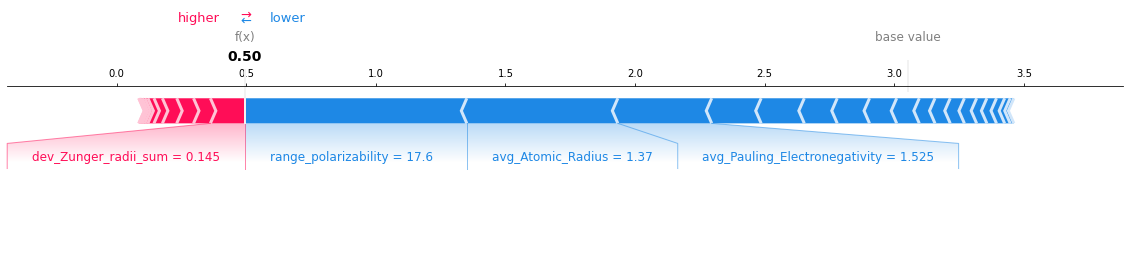

In [118]:
plot_indiv_shap(1) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_LiAl2Cu_1.png', bbox_inches='tight', dpi=1000)

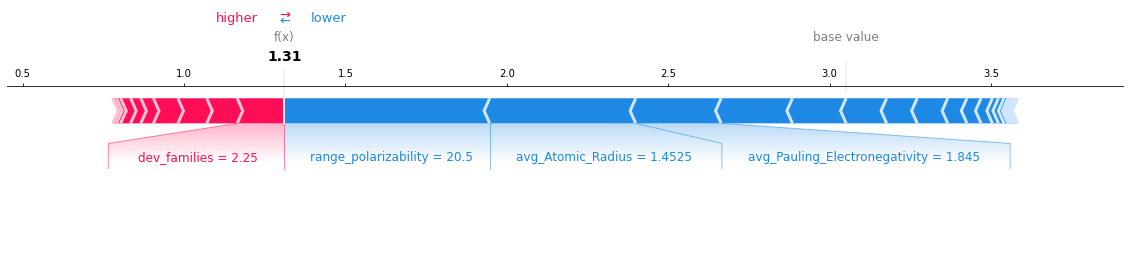

In [119]:
plot_indiv_shap(587) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_LiHfSe2.png', bbox_inches='tight', dpi=1000)

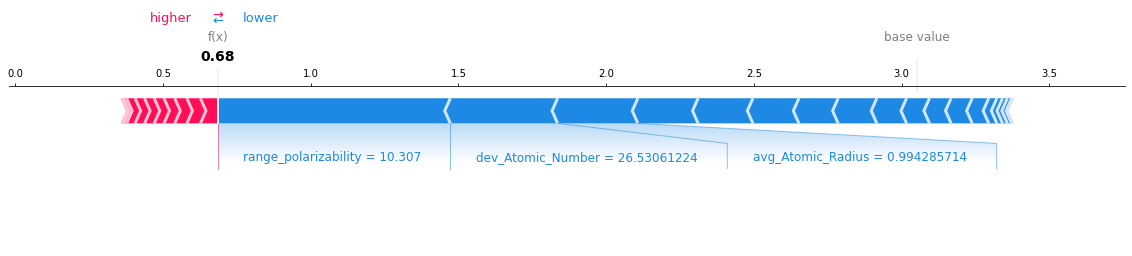

In [120]:
plot_indiv_shap(1527) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_Al(WO2)2.png', bbox_inches='tight', dpi=1000)

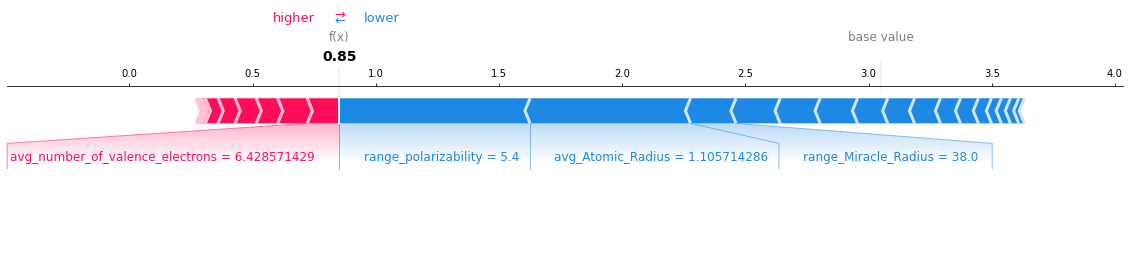

In [121]:
plot_indiv_shap(1547) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_Al(CoS2)2.png', bbox_inches='tight', dpi=1000)

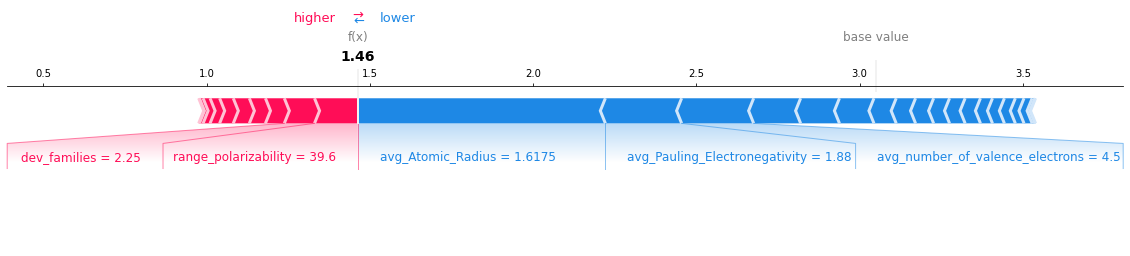

In [122]:
plot_indiv_shap(2009) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_KNbSe2.png', bbox_inches='tight', dpi=1000)

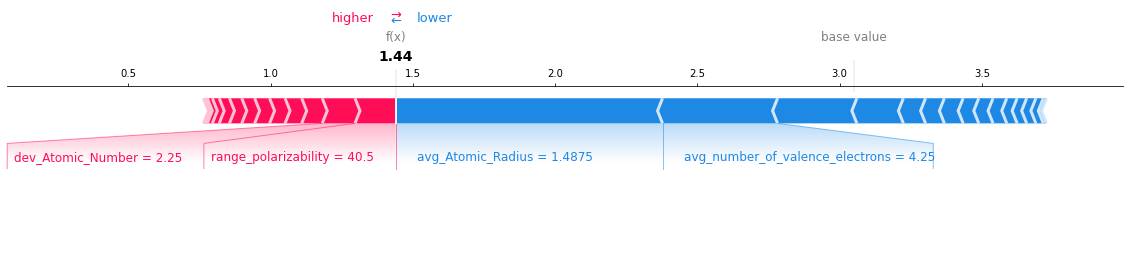

In [123]:
plot_indiv_shap(2042) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_KTiS2.png', bbox_inches='tight', dpi=1000)

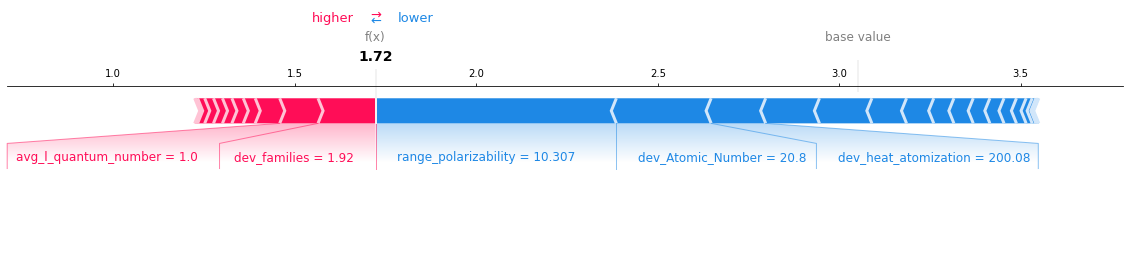

In [124]:
plot_indiv_shap(2236) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_MgWO3.png', bbox_inches='tight', dpi=1000)

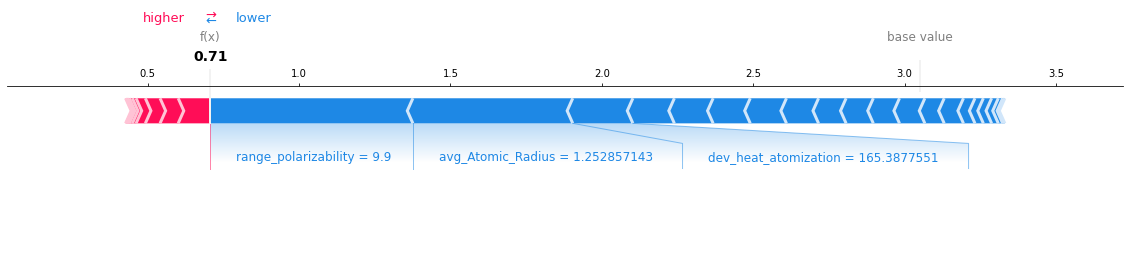

In [125]:
plot_indiv_shap(2311) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_Mg(MoS2)2.png', bbox_inches='tight', dpi=1000)

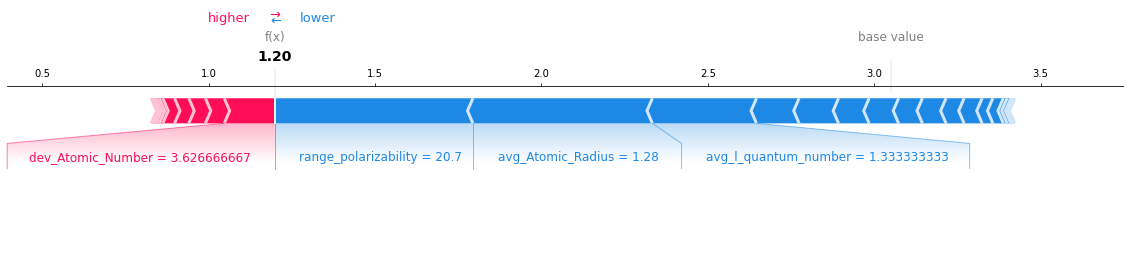

In [126]:
plot_indiv_shap(2496) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_Na(V3S4)2.png', bbox_inches='tight', dpi=1000)

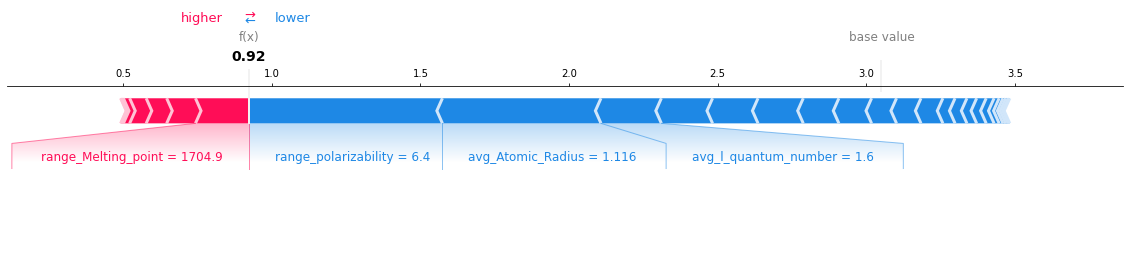

In [129]:
plot_indiv_shap(2761) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_Zn(CoN)2.png', bbox_inches='tight', dpi=1000)

In [156]:
plot_indiv_shap(1859) # for LiAl2Cu
plt.savefig('final_images/local_interpretability.png', bbox_inches='tight', dpi=1000)

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

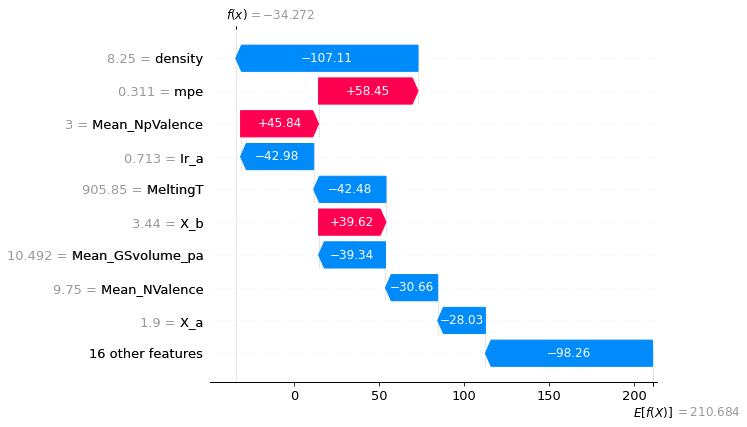

In [22]:
import shap
explainer = shap.Explainer(reg)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0]) # For the Al12Mo observation
#plt.savefig('final_images3/local_interpretability_LiTb4Al2(FeO6)2_2.png', bbox_inches='tight', dpi=1000)

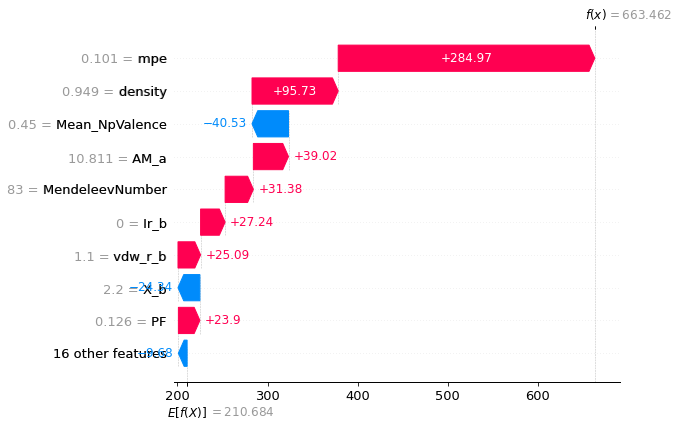

In [23]:
shap.plots.waterfall(shap_values[2]) # For the LiTiSe2 observation
#plt.savefig('final_images/local_interpretability_LiMnAs_2.png', bbox_inches='tight', dpi=1000)

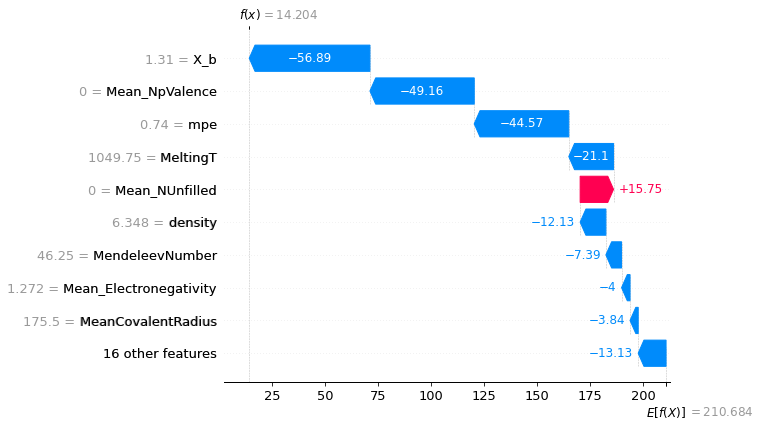

In [24]:
shap.plots.waterfall(shap_values[1]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_LiAl2Cu_2.png', bbox_inches='tight', dpi=1000)

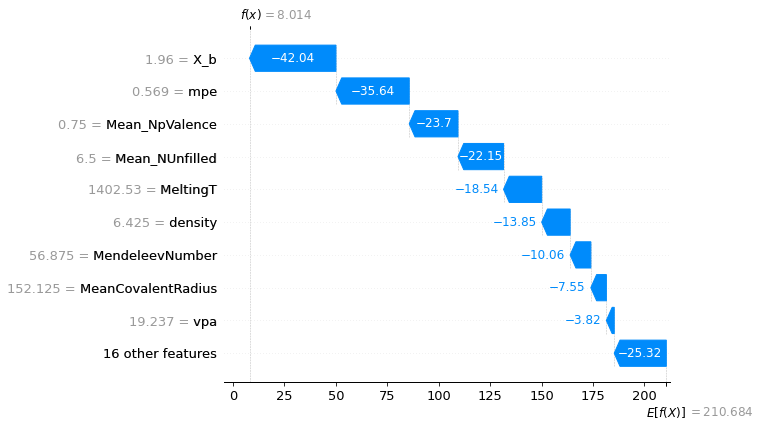

In [25]:
shap.plots.waterfall(shap_values[587]) # For the LiAl2Cu observation
#plt.savefig('final_images3/local_interpretability_LiHfSe2_2.png', bbox_inches='tight', dpi=1000)

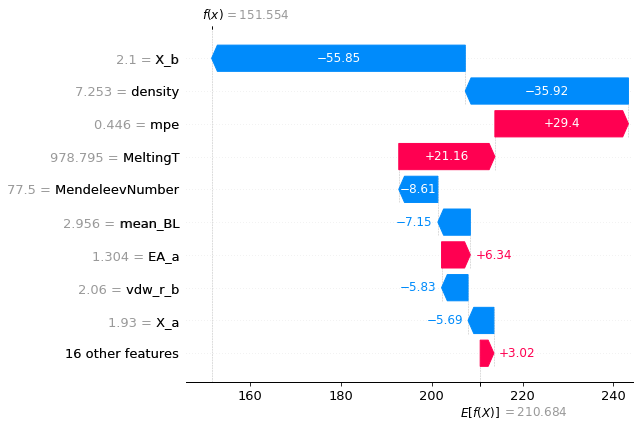

In [26]:
shap.plots.waterfall(shap_values[1527]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_Al(WO2)2_2.png', bbox_inches='tight', dpi=1000)

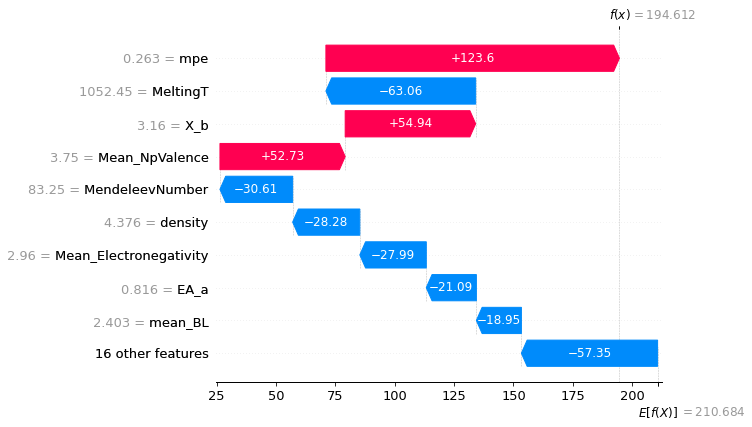

In [27]:
shap.plots.waterfall(shap_values[1547]) # For the LiAl2Cu observation
#plt.savefig('final_images3/local_interpretability_Al(CoS2)2_2.png', bbox_inches='tight', dpi=1000)

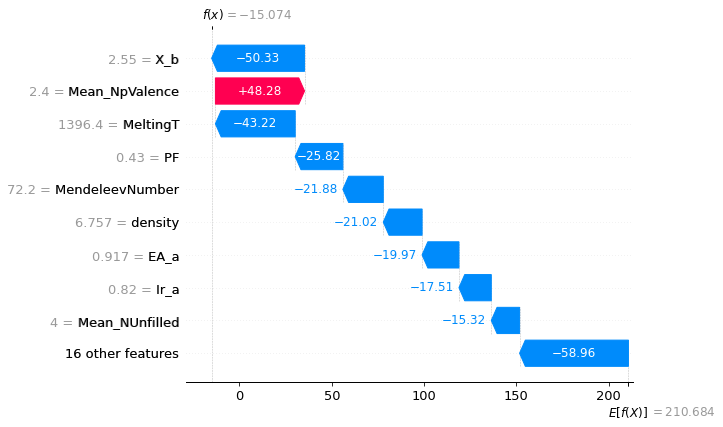

In [28]:
shap.plots.waterfall(shap_values[2009]) # For the LiAl2Cu observation
#plt.savefig('final_images3/local_interpretability_KNbSe2_2.png', bbox_inches='tight', dpi=1000)

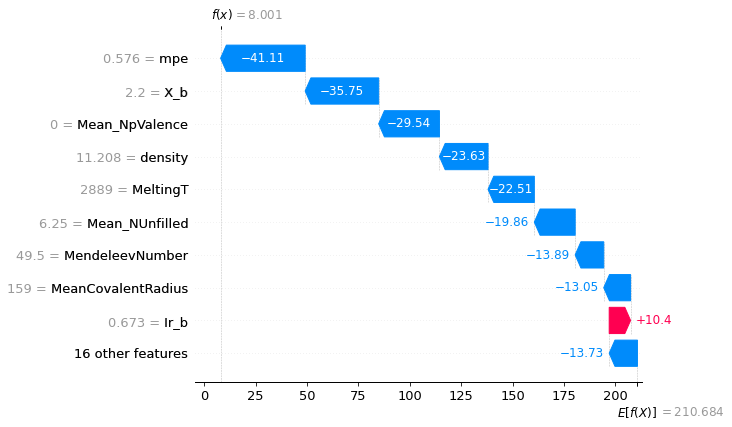

In [29]:
shap.plots.waterfall(shap_values[2042]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_KTiS2_2.png', bbox_inches='tight', dpi=1000)

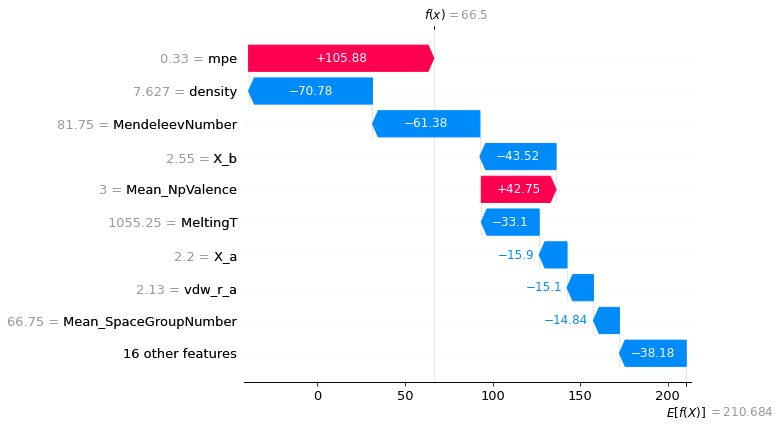

In [30]:
shap.plots.waterfall(shap_values[2236]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_MgWO3_2.png', bbox_inches='tight', dpi=1000)

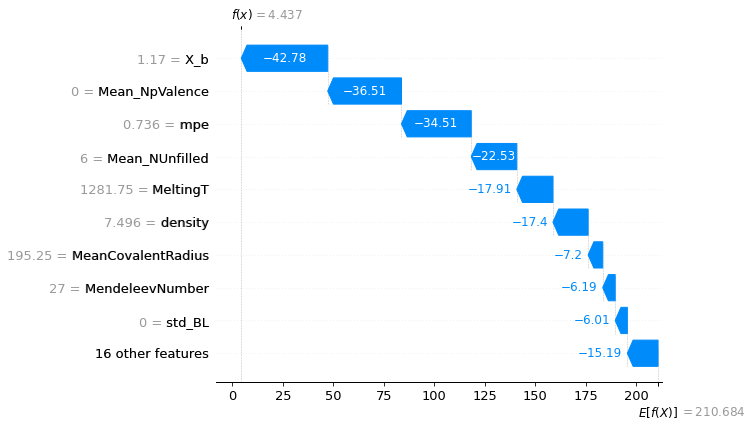

In [31]:
shap.plots.waterfall(shap_values[2311]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_Mg(MoS2)2_2.png', bbox_inches='tight', dpi=1000)

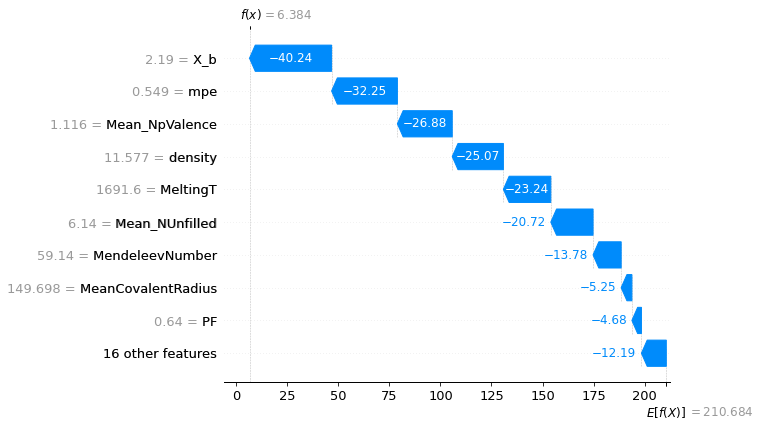

In [32]:
shap.plots.waterfall(shap_values[2496]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_Na(V3S4)2_2.png', bbox_inches='tight', dpi=1000)

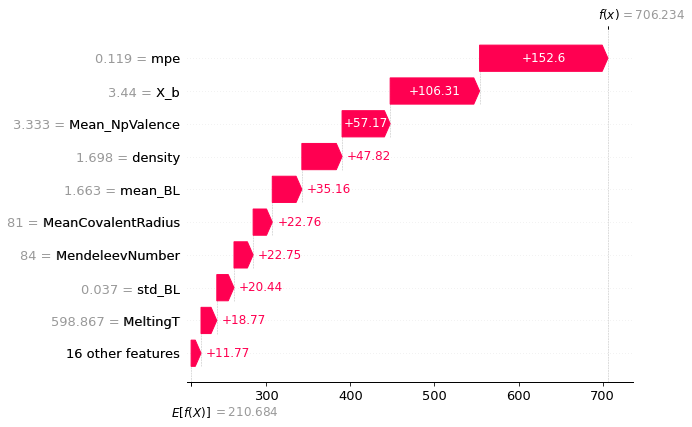

In [33]:
shap.plots.waterfall(shap_values[2761]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_Zn(CoN)2_2.png', bbox_inches='tight', dpi=1000)

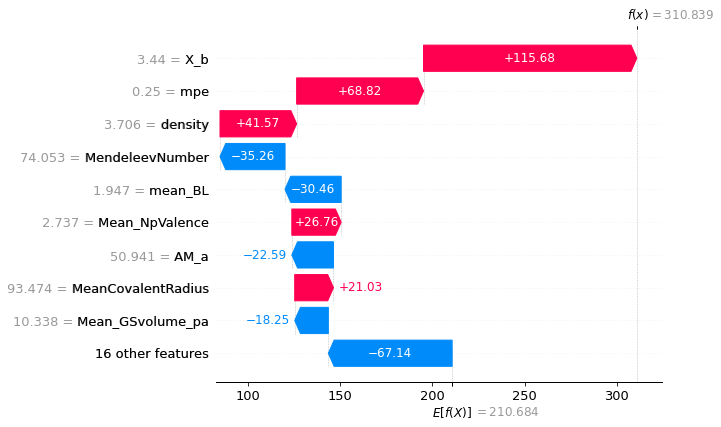

In [34]:
shap.plots.waterfall(shap_values[1820]) # For the LiAl2Cu observation
#plt.savefig('final_images3/local_interpretability_CaFe(PO3)4_2.png', bbox_inches='tight', dpi=1000)

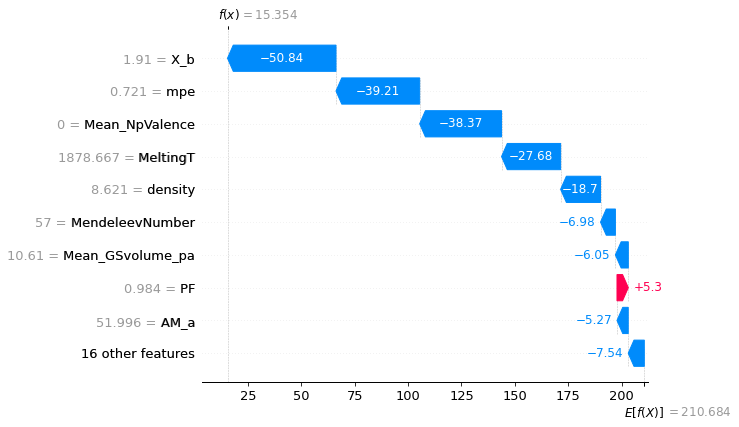

In [35]:
shap.plots.waterfall(shap_values[1806]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_CaTiNiP2O9_2.png', bbox_inches='tight', dpi=1000)